In [30]:
# script for post-processing and analysing the HPC data

# %matplotlib notebook
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time as time
import pandas as pd

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fed9ae', '#fbad54']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [31]:
import glob
import os

In [32]:
files = glob.glob('FORCE/*/*.csv')
len(files)

158

In [36]:
folder = 'FORCE/RUN_0_5'
_df = pd.read_csv(f'{folder}/00000.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'FORCE/RUN_0_5/00000.csv'

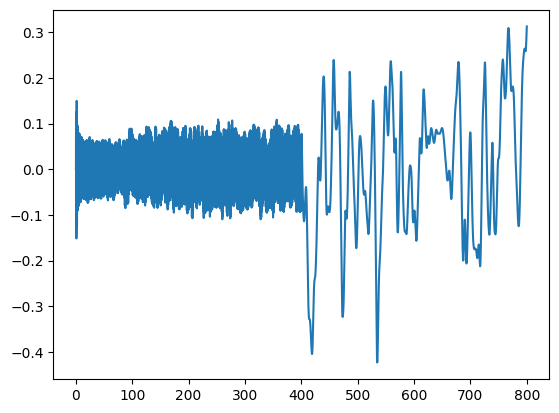

In [35]:
plt.figure()
plt.plot(_df['T'], _df['Z'])

In [26]:
folder = 'FORCE/RUN_0_5'
_df = pd.read_csv(f'{folder}/00000.csv')
t = _df['T'].values

dataZ = np.zeros((len(t), 576 * 5 + 1))
dataZ[:, 0] = t

dataE = np.zeros((len(t), 576 * 5 + 1))
dataE[:, 0] = t

for i in range(576 * 5):
    print('processing {0}'.format(i), end = '\r')
    _df = pd.read_csv(f'{folder}/{i:05d}.csv')
    _z = _df['Z'].values
    _e = _df['E'].values
    dataZ[:, i + 1] = _z
    dataE[:, i + 1] = _e
    os.remove(f'{folder}/{i:05d}.csv')
dfE = pd.DataFrame.from_records(dataE, columns = ['T', *np.arange(576 * 5)])
dfZ = pd.DataFrame.from_records(dataZ, columns = ['T', *np.arange(576 * 5)])
dfE.to_csv(f'{folder}/summaryE.csv', index = False)
dfZ.to_csv(f'{folder}/summaryZ.csv', index = False)

In [27]:
dfs = [pd.read_csv(f'{folder}/summaryE.csv'),
       #pd.read_csv('RUN_5_10/summary.csv'),
       #pd.read_csv('RUN_10_15/summary.csv'),
       #pd.read_csv('RUN_15_20/summary.csv'),
      ]

t = dfs[0]['T'].values

In [28]:
error_train = np.zeros((24, 24, 20))
error_test = np.zeros((24, 24, 20))

per_lst = np.linspace(0, np.log10(200), 24)
amp_lst = np.linspace(-1, np.log10(20), 24)

tCut = 400

dTm = 400
dTp = 400

for dfIdx in range(len(dfs)):
    df = dfs[dfIdx]
    
    for i in range(576 * 5):
        if i % 10 == 0:
            print('{0:05d}-{1:05d}'.format(dfIdx, i), end = '\r')

        _sys_idx = i % 5
        _sec_idx = i // 5

        _per_idx = _sec_idx % 24
        _amp_idx = _sec_idx // 24

        _per = 10 ** per_lst[_per_idx]
        _amp = 10 ** amp_lst[_amp_idx]
        _e = df['{0}'.format(i)].values ** 2

        maskm = (tCut - dTm < t) & (t < tCut)
        maskp = (tCut < t) & (t < tCut + dTp)

        error_train[_amp_idx, _per_idx, _sys_idx + dfIdx * 5] = np.sqrt(np.mean(_e[maskm])) / _amp
        error_test[_amp_idx, _per_idx, _sys_idx + dfIdx * 5] = np.sqrt(np.mean(_e[maskp])) / _amp


In [23]:
error_train = np.zeros((24, 24, 20))
error_test = np.zeros((24, 24, 20))

per_lst = np.linspace(0, np.log10(200), 24)
amp_lst = np.linspace(-1, np.log10(20), 24)

tCut = 400

dTm = 400
dTp = 400

for dfIdx in range(len(dfs)):
    df = dfs[dfIdx]
    
    for i in range(576 * 5):
        if i % 10 == 0:
            print('{0:05d}-{1:05d}'.format(dfIdx, i), end = '\r')

        _sys_idx = i % 5
        _sec_idx = i // 5

        _per_idx = _sec_idx % 24
        _amp_idx = _sec_idx // 24

        _per = 10 ** per_lst[_per_idx]
        _amp = 10 ** amp_lst[_amp_idx]
        _f = _amp * np.sin(2 * np.pi * t / _per)
        _z = df['{0}'.format(i)].values
        _e = (_z - _f) ** 2

        maskm = (tCut - dTm < t) & (t < tCut)
        maskp = (tCut < t) & (t < tCut + dTp)

        error_train[_amp_idx, _per_idx, _sys_idx + dfIdx * 5] = np.sqrt(np.mean(_e[maskm])) / _amp
        error_test[_amp_idx, _per_idx, _sys_idx + dfIdx * 5] = np.sqrt(np.mean(_e[maskp])) / _amp


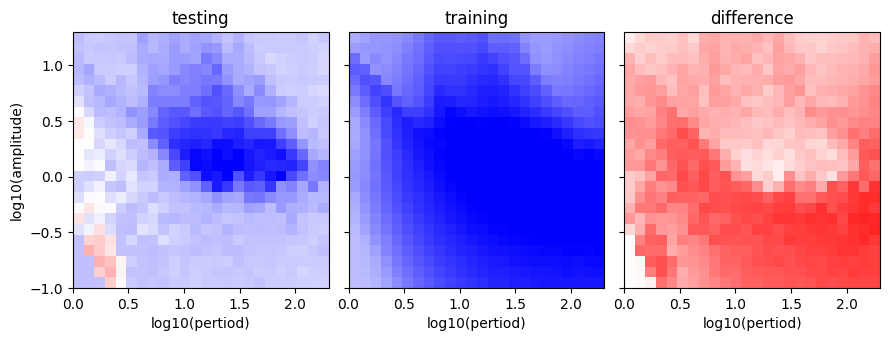

In [29]:
fig, axes = plt.subplots(1, 3, figsize = (9, 4), sharex = True, sharey = True)

vv = 3

er_te = np.log10(np.mean(error_test, axis = -1))
er_tr = np.log10(np.mean(error_train, axis = -1))
extent = (per_lst[0], per_lst[-1], amp_lst[0], amp_lst[-1])

axes[0].imshow(er_te, origin = 'lower', cmap = 'bwr',
               extent = extent, vmin = -vv, vmax = vv)

axes[1].imshow(er_tr, origin = 'lower', cmap = 'bwr',
               extent = extent, vmin = -vv, vmax = vv)

axes[2].imshow(er_te - er_tr, origin = 'lower', cmap = 'bwr',
               extent = extent, vmin = -vv, vmax = vv)

axes[0].set_title('testing')
axes[1].set_title('training')
axes[2].set_title('difference')

axes[0].set_ylabel('log10(amplitude)')
for i in range(3):
    axes[i].set_xlabel('log10(pertiod)')

plt.tight_layout()
plt.show()
# plt.savefig('summary.png')

/tmp/ipykernel_3370395/2967503090.py:5: RuntimeWarning: divide by zero encountered in log10
  axes[i, 0].imshow(np.log10(error_test[:, :, sys]), origin = 'lower', cmap = 'bwr',
/tmp/ipykernel_3370395/2967503090.py:8: RuntimeWarning: divide by zero encountered in log10
  axes[i, 1].imshow(np.log10(error_train[:, :, sys]), origin = 'lower', cmap = 'bwr',
/tmp/ipykernel_3370395/2967503090.py:11: RuntimeWarning: divide by zero encountered in log10
  axes[i, 2].imshow(np.log10(error_test[:, :, sys]) - np.log10(error_train[:, :, sys]), origin = 'lower', cmap = 'bwr',
/tmp/ipykernel_3370395/2967503090.py:11: RuntimeWarning: invalid value encountered in subtract
  axes[i, 2].imshow(np.log10(error_test[:, :, sys]) - np.log10(error_train[:, :, sys]), origin = 'lower', cmap = 'bwr',


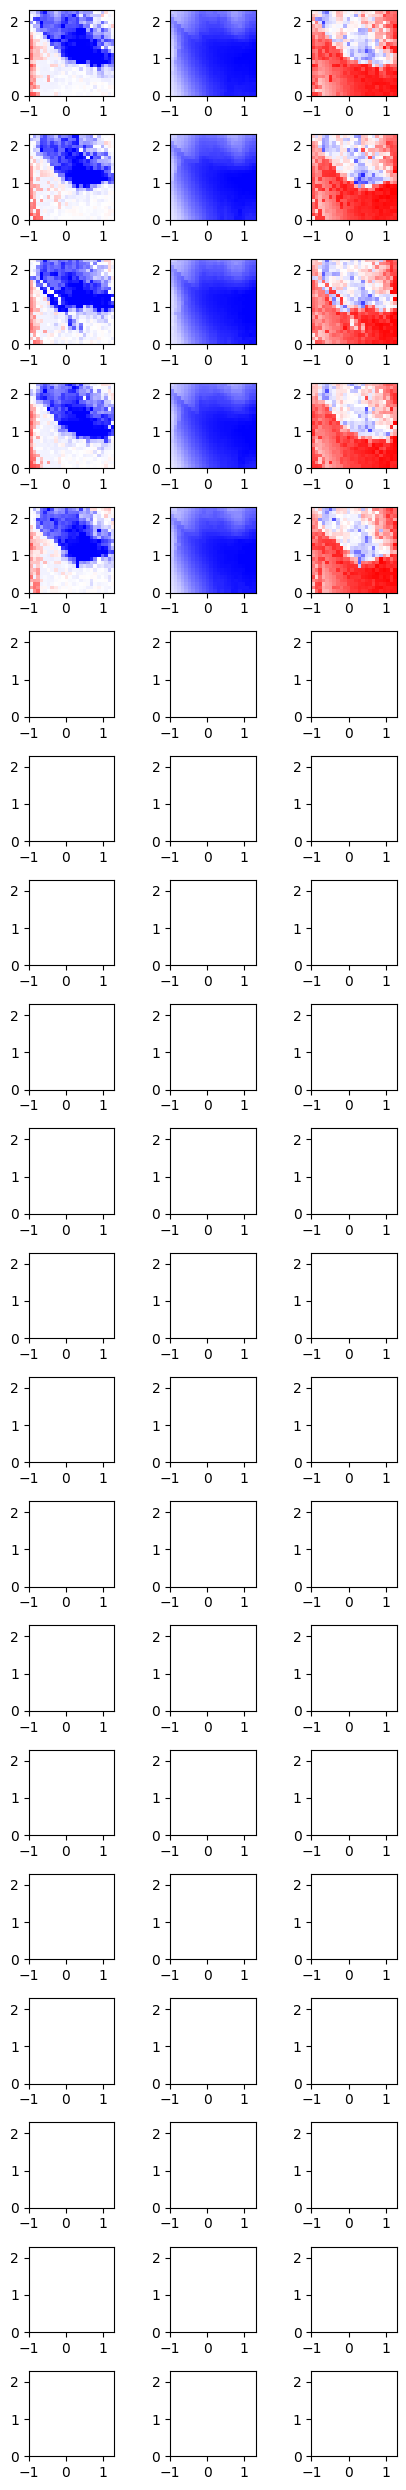

In [20]:
fig, axes = plt.subplots(20, 3, figsize = (4.5, 25))

for i in range(20):
    sys = i
    axes[i, 0].imshow(np.log10(error_test[:, :, sys]), origin = 'lower', cmap = 'bwr',
                   extent = (amp_lst[0], amp_lst[-1], per_lst[0], per_lst[-1]), vmin = -3, vmax = 3)

    axes[i, 1].imshow(np.log10(error_train[:, :, sys]), origin = 'lower', cmap = 'bwr',
                   extent = (amp_lst[0], amp_lst[-1], per_lst[0], per_lst[-1]), vmin = -3, vmax = 3)

    axes[i, 2].imshow(np.log10(error_test[:, :, sys]) - np.log10(error_train[:, :, sys]), origin = 'lower', cmap = 'bwr',
                   extent = (amp_lst[0], amp_lst[-1], per_lst[0], per_lst[-1]), vmin = -3, vmax = 3)
plt.tight_layout()
# plt.savefig('all.png')